<a href="https://colab.research.google.com/github/kangjunseo/Bioinformatics/blob/main/GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 7.9 MB 39.6 MB/s 
     |████████████████████████████████| 3.5 MB 32.0 MB/s 
     |████████████████████████████████| 2.4 MB 69.8 MB/s 
     |████████████████████████████████| 709 kB 39.9 MB/s 
     |████████████████████████████████| 467 kB 37.8 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0.post1-py3-none-any.whl size=689859 sha256=fec5d1fab08a75604e99d04513f7ef9c3bf337d47a06c3fbd43e096b5bfb1691
  Stored in directory: /root/.cache/pip/wheels/d1/cb/43/f7f2e472de4d7cff31bceddadc36d634e1e545fbc17961c282
Successfully built torch-geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/publ

In [5]:
import torch
from pytorch_lightning import LightningModule

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root=',/data', train=False, download=True, transform=transform)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print('*==========Train Set==========*')
print(train_set)
print('*========== Test Set ==========*')
print(test_set)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ,/data/cifar-10-python.tar.gz to ,/data
*==========Train Set==========*
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
*========== Test Set ==========*
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ,/data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


(3, 32, 32)
truck-9


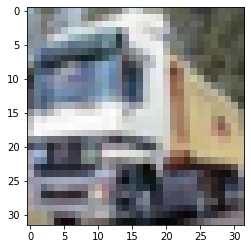

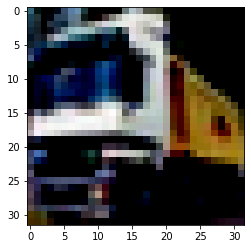

In [7]:
import matplotlib.pyplot as plt
import numpy as np

img = train_set[1][0]
label = train_set[1][1]
img = img.numpy()

print(img.shape)
print(f'{classes[label]}-{label}')

origin_img = img / 2 + 0.5 # unnormalized
plt.imshow(np.transpose(origin_img, (1, 2, 0)))
plt.show()


plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

In [8]:
from torch.utils.data import DataLoader
from pytorch_lightning import LightningDataModule
from torch_geometric.data import Data, Batch
from torch.nn.functional import pad

class CustomData(LightningDataModule):
  def __init__(self, training_set, validation_set, test_set, batch_size=128, num_workers=1):
    super().__init__()
    self.training_set = training_set
    self.validation_set = validation_set
    self.test_set = test_set
    self.batch_size = batch_size
    self.num_workers = num_workers

  #how to make a batch
  def collate_function(self, batch):    
    return Batch.from_data_list([Data(edge_index=data.edge_index,
                                      x=pad(data.x, (0,3), 'constant', 0.)[:,:53],
                                      edge_attr=data.edge_attr,
                                      y=data.y.unsqueeze(0).float()) for data in batch])

  def train_dataloader(self):
    return DataLoader(self.training_set, batch_size=self.batch_size, 
                      num_workers=self.num_workers, shuffle=True, 
                      collate_fn=self.collate_function)
    
  def val_dataloader(self):
    return DataLoader(self.validation_set, batch_size=self.batch_size, 
                      num_workers=self.num_workers, shuffle=True, 
                      collate_fn=self.collate_function)

  def test_dataloader(self):
    return DataLoader(self.test_set, batch_size=self.batch_size, 
                      num_workers=self.num_workers, 
                      collate_fn=self.collate_function)


In [9]:
from torch.nn import Module, Linear
from torch_geometric.nn import GATConv, global_mean_pool

class CustomGAT(Module):
  def __init__(self, input_size, label_size, layer_size=64, dropout=0.1, heads=2):
    super().__init__()
    self.input_size = input_size
    self.label_size = label_size
    self.layer_size = layer_size
    self.dropout = dropout
    self.heads = heads
    self.setup()

  def setup(self):
    self.first_layer = GATConv(self.input_size, self.layer_size, dropout=self.dropout, heads=self.heads, concat=False)
    self.last_layer = GATConv(self.layer_size, self.layer_size, dropout=self.dropout, heads=self.heads, concat=False)
    self.ffnn = Linear(self.layer_size, self.label_size)

  def convert_graph_into_single_vector(self, graph_hidden, batch_index):
    return global_mean_pool(graph_hidden, batch_index)

  def forward(self, batch):
    z = self.first_layer(batch.x, batch.edge_index)
    z = self.last_layer(z, batch.edge_index)
    z = self.convert_graph_into_single_vector(z, batch.batch)
    z = self.ffnn(z)
    return z

In [10]:
from torch_geometric.datasets import TUDataset

training_dataset = TUDataset('./dataset', 'Tox21_AhR_training')
validation_dataset = TUDataset('./dataset', 'Tox21_AhR_testing')
test_dataset = TUDataset('./dataset', 'Tox21_AhR_evaluation')

Extracting dataset/Tox21_AhR_training/Tox21_AhR_training.zip
Processing...
Done!
Extracting dataset/Tox21_AhR_testing/Tox21_AhR_testing.zip
Processing...
Done!
Extracting dataset/Tox21_AhR_evaluation/Tox21_AhR_evaluation.zip
Processing...
Done!


In [13]:
from pytorch_lightning import LightningModule
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam

class CustomModel(LightningModule):
  def __init__(self, model, learning_rate=1e-3):
    super().__init__()
    self.model = model
    self.lr = learning_rate

  def forward(self, batch, mode):
    z = self.model(batch)
    loss = self.loss_function(z, batch.y)
    self.log(f"{mode}_loss", loss, batch_size=batch.y.size(0), prog_bar=True, on_step=False, on_epoch=True)
    return loss, z, batch.y

  def training_step(self, batch, batch_idx):
    loss, predict, answer = self(batch, 'train')
    return {'loss':loss, 'predict':predict, 'answer':answer}

  def validation_step(self, batch, batch_idx):
    loss, predict, answer = self(batch, 'val')
    return {'loss':loss, 'predict':predict, 'answer':answer}

  def test_step(self, batch, batch_idx):
    loss, predict, answer = self(batch, 'test')
    return {'loss':loss, 'predict':predict, 'answer':answer}

  def predict_step(self, batch, batch_idx):
    predict = self.model(batch)
    return predict

  def loss_function(self, output, target):
    return BCEWithLogitsLoss(reduction='mean')(output, target)

  def configure_optimizers(self):
    optimizer = Adam(self.parameters(), lr=self.lr)
    return optimizer

In [14]:
from pytorch_lightning import Trainer

import warnings
warnings.filterwarnings(action='ignore')

data_module = CustomData(training_dataset, validation_dataset, test_dataset)

gat = CustomGAT(53, 1)
model = CustomModel(gat)

trainer = Trainer(max_epochs=1, accelerator='gpu', devices=[0])
trainer.fit(model, datamodule=data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type      | Params
------------------------------------
0 | model | CustomGAT | 15.7 K
------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [16]:
from torchmetrics.functional import auroc

outputs = trainer.predict(model, dataloaders=data_module.test_dataloader())
y = torch.concat(outputs)
x = torch.concat([batch.y for batch in data_module.test_dataloader()]).int()

evaluation = auroc(y, x)
print(f"auc-roc: {evaluation}")

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 64it [00:00, ?it/s]

auc-roc: 0.4305001199245453
